In [167]:
!pip install cpi

In [168]:
# IMPORTS
import datetime as dt
import pandas as pd
import numpy as np
import cpi
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline

## Read the datasets

In [169]:
#load data from CPI module
bls_cpi_df = cpi.series.get(seasonally_adjusted=False).to_dataframe()

In [170]:
bls_cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   series_id            1453 non-null   object 
 1   year                 1453 non-null   int64  
 2   date                 1453 non-null   object 
 3   value                1453 non-null   float64
 4   period_id            1453 non-null   object 
 5   period_code          1453 non-null   object 
 6   period_abbreviation  1453 non-null   object 
 7   period_name          1453 non-null   object 
 8   period_month         1453 non-null   int64  
 9   period_type          1453 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 113.6+ KB


In [171]:
#load data from CSV
sp_500 = pd.read_csv("../Resources/data/sp_500_ds.csv", index_col="Date", parse_dates=True).dropna()
sp_500.head(3)

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2014-01-02,1845.86,1845.86,1827.74,1831.98,1831.98,3080600000
2014-01-03,1833.21,1838.24,1829.13,1831.37,1831.37,2774270000
2014-01-06,1832.31,1837.16,1823.73,1826.77,1826.77,3294850000


In [172]:
#load data from CSV
inf_us_yrly = pd.read_csv("../Resources/data/inf_cpi_us_yrly_ds.csv", index_col="date", parse_dates=True).dropna()
inf_us_yrly.tail(3)

,chgprc
date,
2022-01-01,8.002800
2023-01-01,4.116338
2024-01-01,3.012415


In [173]:
#load data from CSV
inf_us_mtly = pd.read_csv("../Resources/data/inf_cpi_us_mtly_ds.csv", index_col="date", parse_dates=True)
inf_us_mtly.tail(3)

,value
date,
2024-10-01,315.45
2024-11-01,316.44
2024-12-01,317.65


## Data Pre-processing

In [174]:
#function to return length of periods in dataframe
def len_periods(df, beginning, end):
    return len(df[(beginning <= df['year']) & (df['year'] <= end)].nunique())

#function to calc the 2% avg rate of inflation
def get_target_cpi(previous_cpi):
    return previous_cpi + 0.02*(previous_cpi)

In [175]:
#filter period to monthly, convert date to datetime and set as index
bls_cpi_df = bls_cpi_df[bls_cpi_df['period_type']=='monthly']
bls_cpi_df['date'] = pd.to_datetime(bls_cpi_df['date'])
bls_cpi_df = bls_cpi_df.set_index('date')

#sort index
bls_cpi_df = bls_cpi_df.sort_index().loc['2015':'2023', :] 

#Targeting a 2% inflation rate since 2015, add a line to same plot to starting with the 2015 value
start = bls_cpi_df['value'].loc['2015':'2023'].iloc[0]
#return period count
periods = len_periods(bls_cpi_df, 2015, 2023)
#take start date, iterate periods, calc 2%, append to list
target_cpis = [start]
for year in range(0,periods):
    target_cpis.append(get_target_cpi(target_cpis[year]))
#generate date range
dates = pd.date_range('2015-01-01','2023-12-31',periods=periods+1)
#convert to series
target_cpi_series = pd.Series(data =target_cpis, index= dates)

In [176]:
annual_data_list = []
# get the unique years in the dataset
year_list = sp_500.index.year.unique()
for year in year_list:
    last_day_data = sp_500[sp_500.index.year == year].tail(1)
    annual_data_list.append(last_day_data)
sp500_annual = pd.concat(annual_data_list)
#calculate the annual performance as a percentage change between the last day of the year and the last day of the previous year
sp500_annual_performance = sp500_annual[["Close"]] / sp500_annual[["Close"]].shift(1) * 100 - 100
sp500_annual_performance.index = pd.to_datetime(sp500_annual_performance.index.strftime("%Y"))  # reset index to YYYY-01-01
sp500_annual_performance

,Close
Date,
2014-01-01,NaN
2015-01-01,-0.726602
2016-01-01,9.535016
2017-01-01,19.419965
2018-01-01,-6.237260
2019-01-01,28.878074
2020-01-01,16.258922
2021-01-01,26.892736
2022-01-01,-19.442824


In [177]:
#clear NaN values
sp500_annual_performance.dropna(inplace=True)
sp500_annual_performance

,Close
Date,
2015-01-01,-0.726602
2016-01-01,9.535016
2017-01-01,19.419965
2018-01-01,-6.237260
2019-01-01,28.878074
2020-01-01,16.258922
2021-01-01,26.892736
2022-01-01,-19.442824
2023-01-01,24.230499


In [178]:
monthly_data_list = []
# get the unique months in the dataset
month_list = sorted(sp_500.index.month.unique())
for year in year_list:
    for month in month_list:
        last_day_data = sp_500[(sp_500.index.year == year) & (sp_500.index.month == month)].tail(1)
        monthly_data_list.append(last_day_data)
sp500_monthly = pd.concat(monthly_data_list)
#calculate the monthly performance as a percentage change between the last day of the month and the last day of the previous month
sp500_monthly_performance = sp500_monthly[["Close"]] / sp500_monthly[["Close"]].shift(1) * 100 - 100
sp500_monthly_performance.index = pd.to_datetime(
    sp500_monthly_performance.index.strftime("%Y-%m"))  # reset index to YYYY-01-01
sp500_monthly_performance

,Close
Date,
2014-01-01,NaN
2014-02-01,4.311704
2014-03-01,0.693216
2014-04-01,0.620080
2014-05-01,2.103028
...,...
2024-08-01,2.283469
2024-09-01,2.019687
2024-10-01,-0.989678


In [179]:
#clear NaN values
sp500_monthly_performance.dropna(inplace=True)
sp500_monthly_performance

,Close
Date,
2014-02-01,4.311704
2014-03-01,0.693216
2014-04-01,0.620080
2014-05-01,2.103028
2014-06-01,1.905831
...,...
2024-08-01,2.283469
2024-09-01,2.019687
2024-10-01,-0.989678


## Visualizations
### Range - Pre- and Post-Pandemic (2015-2023)

* CPI - Inflation Rate
* CPI - True Inflation Percentage
* S&P 500 Historical price
* CPI change % vs S&P 500 Annual Returns
* Annual relationshipo in scatter plot

### Consumer Price Index (CPI): Inflation Rate

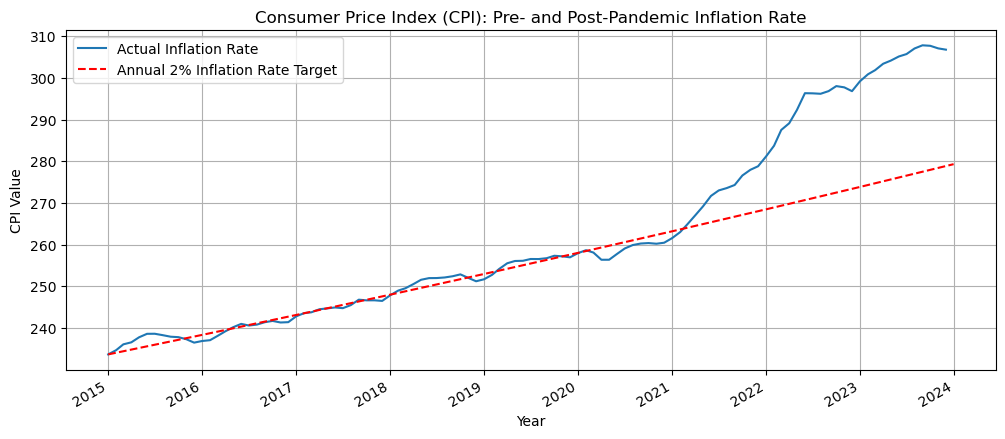

In [180]:
fig = plt.figure(figsize=(12,5))
plt.plot(bls_cpi_df['value'].loc['2015':'2023'], label='Actual Inflation Rate')
target_cpi_series.plot(ls='--',c='red',label='Annual 2% Inflation Rate Target') 
plt.title("Consumer Price Index (CPI): Pre- and Post-Pandemic Inflation Rate")
plt.xlabel("Year")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)

## Analysis
* The actual inflation rate holds steady on the 2% average a year into the pandemic but an increase the cost of goods was caused by excessive government spending resulting in the devaluation of the dollar and low interest rates.

### Consumer Price Index (CPI): True Inflation percentage

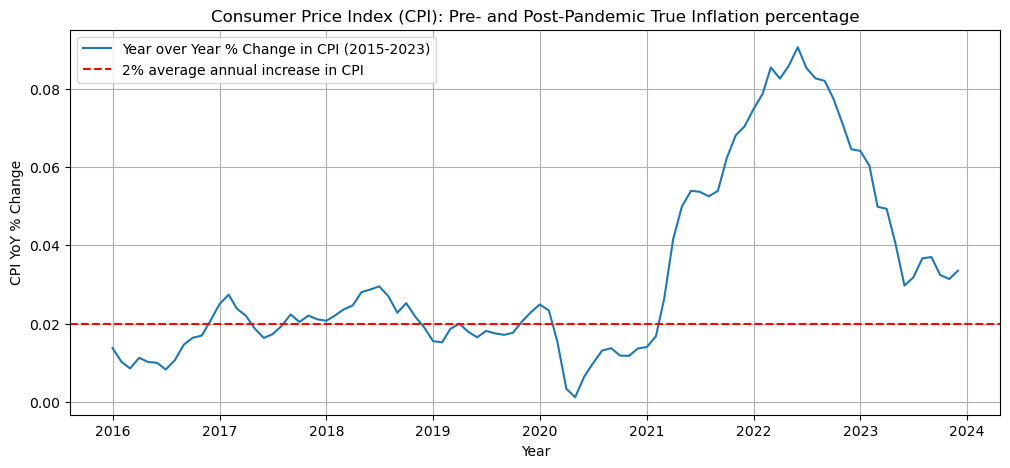

In [181]:
fig = plt.figure(figsize=(12,5))
plt.plot(bls_cpi_df['value'].loc['2015':'2023'].pct_change(12), label='Year over Year % Change in CPI (2015-2023)')
plt.axhline(0.02,ls='--',c='red',label='2% average annual increase in CPI')
plt.title("Consumer Price Index (CPI): Pre- and Post-Pandemic True Inflation percentage")
plt.xlabel("Year")
plt.ylabel("CPI YoY % Change")
plt.legend()
plt.grid(True)

## Analysis
* The true inflation percentage matches the CPI inflation rate starting in second quarter of 2020 and early 2021.

### CPI vs. S&P 500 Annual Returns

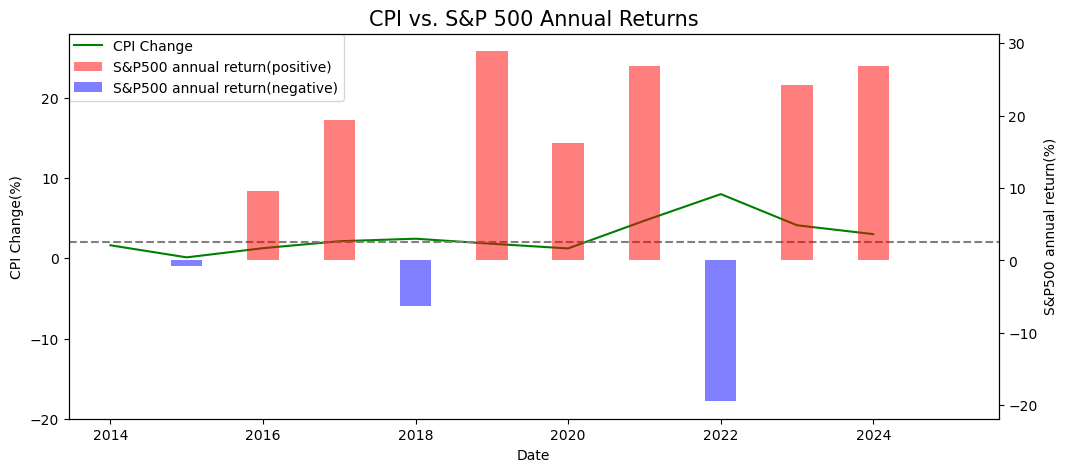

In [182]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
ax1.plot(inf_us_yrly.index, inf_us_yrly,
         color="green", label="CPI Change")
sp500_annual_performance_plus = sp500_annual_performance[sp500_annual_performance >= 0]
ax2.bar(sp500_annual_performance_plus.index, sp500_annual_performance_plus["Close"],
        color="red", alpha=0.5, width=1500 / len(sp500_annual_performance_plus), label="S&P500 annual return(positive)")
sp500_annual_performance_minus = sp500_annual_performance[sp500_annual_performance < 0]
ax2.bar(sp500_annual_performance_minus.index, sp500_annual_performance_minus["Close"],
        color="blue", alpha=0.5, width=1500 / len(sp500_annual_performance_minus), label="S&P500 annual return(negative)")
ax1.axhline(2, color='gray', linestyle='--')
plt.tick_params(labelsize=10)  # font size of tick labels
plt.title("CPI vs. S&P 500 Annual Returns", fontsize=15)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
ax1.set_xlabel("Date")
ax1.set_ylabel("CPI Change(%)")
ax2.set_ylabel("S&P500 annual return(%)")
ax1.set_ylim([-20, 28])

ax1.set_xlim([min(inf_us_yrly.index) - dt.timedelta(days=200),
              max(inf_us_yrly.index) + dt.timedelta(days=600)])
plt.show()

## Analysis
* It appears that when the stock market is down, inflation is up but as you can see by 2015 both were slightly down.

### CPI vs. S&P 500 Yearly Relationship

c:\Users\37065890\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


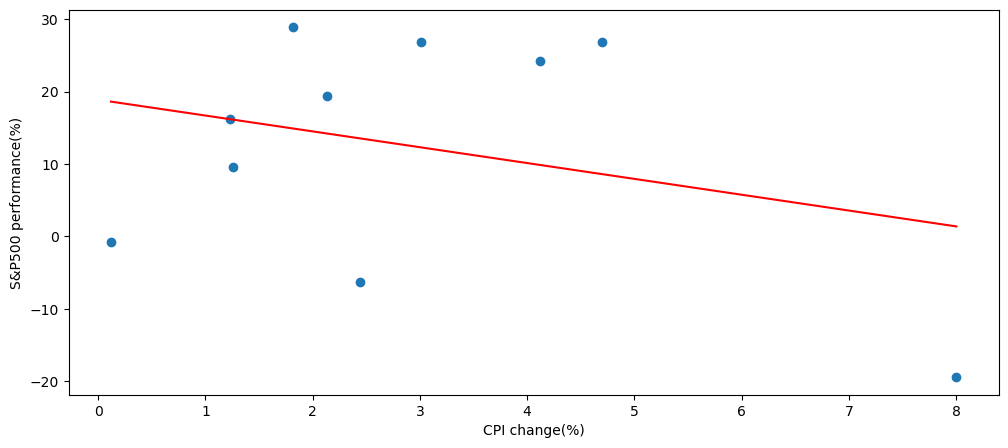

In [183]:
merge_df = pd.merge(inf_us_yrly, sp500_annual_performance, left_index=True, right_index=True)
merge_df.rename(columns={"chgprc": "CPI", "Close": "SP500"}, inplace=True)
model = LinearRegression()
model_reg = model.fit(merge_df[["CPI"]], merge_df["SP500"])
reg_curve_x = np.linspace(min(merge_df["CPI"]), max(merge_df["CPI"]))
reg_curve_y = model_reg.predict(reg_curve_x.reshape(-1, 1))
fig = plt.figure(figsize=(12,5))
plt.scatter(merge_df["CPI"], merge_df["SP500"])
plt.plot(reg_curve_x, reg_curve_y, color="red")
plt.xlabel("CPI change(%)")
plt.ylabel("S&P500 performance(%)")
plt.show()

In [184]:
merge_df.corr()

,CPI,SP500
CPI,1.000000,-0.300145
SP500,-0.300145,1.000000


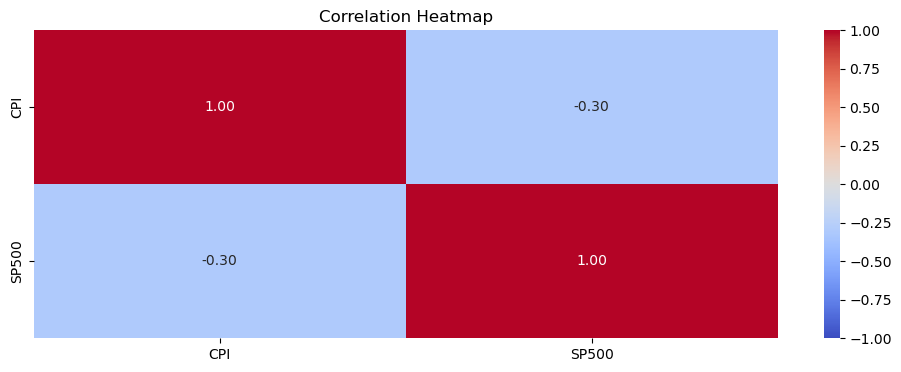

In [187]:
#Correlation heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(merge_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Analysis
* The trend seems to that the larger the CPI rate increase, the worse the S&P 500 performs. This is not always true because some y-values are high even when the x-axis is large.
* Considering that most points do not follow or land near the regression as well as a -0.30 correlation value, I believe a weak negative correlation exists between CPI % amd S&P Annual % Performance